In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
os.environ['TORCH_HOME'] = "/media/hdd/Datasets/"
import sys
sys.path.append("../../../sprintdl/")

In [2]:
from sprintdl.main import *
import sprintdl

In [3]:
device = torch.device('cuda',0)
from torch.nn import init
import torch
import math

# Define required

In [12]:
fpath = Path("/media/hdd/Datasets/imagewoof2-160/")

train_transform = [A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ]

tfms = [ATransform(train_transform, c_in = 3)]
bs = 256

# Actual process

In [13]:
il = ImageList.from_files(fpath, tfms=tfms)

In [14]:
il

ImageList (12954 items)
[PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/n02115641_8554.JPEG'), PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/n02115641_4035.JPEG'), PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/n02115641_13405.JPEG'), PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/n02115641_50879.JPEG'), PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/n02115641_14617.JPEG'), PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/n02115641_15723.JPEG'), PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/n02115641_8595.JPEG'), PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/n02115641_10705.JPEG'), PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/ILSVRC2012_val_00002786.JPEG'), PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/n02115641_32024.JPEG')...]
Path: /media/hdd/Datasets/imagewoof2-160

In [15]:
tm= Path("/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/69030963_140928767119437_3621699865915593113_n.jpg")

In [16]:
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid = .2))
ll = label_by_func(sd, lambda x: str(x).split("/")[-3], proc_y=CategoryProcessor())

In [17]:
n_classes = len(set(ll.train.y.items))

In [18]:
data = ll.to_databunch(bs, c_in=3, c_out=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


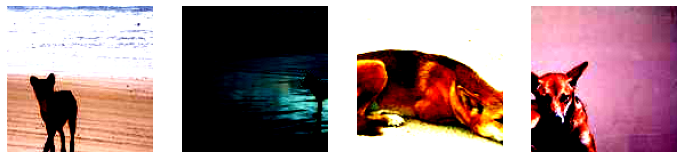

In [19]:
show_batch(data, 4)

# Training

In [20]:
lr = .001
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

cbfs = [
    partial(AvgStatsCallback,accuracy),
    partial(ParamScheduler, 'lr', sched_lr),
    partial(ParamScheduler, 'mom', sched_mom),
        partial(BatchTransformXCallback, norm_imagenette),
    ProgressCallback,
    Recorder,
#     MixUp,
       partial(CudaCallback, device)]

loss_func=LabelSmoothingCrossEntropy()
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

# FNet
- https://github.com/rishikksh20/FNet-pytorch/blob/master/fnet.py

In [26]:
# class FeedForward(nn.Module):
#     def __init__(self, dim, hidden_dim, dropout = 0.):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(dim, hidden_dim),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dim, dim),
#             nn.Dropout(dropout),
#         )
#     def forward(self,x):
#         return self.net(x)

# class PreNorm(nn.Module):
#     def __init__(self, dim, fn):
#         super().__init__()
#         self.norm = nn.LayerNorm(dim)
#         self.fn = fn
#     def forward(self,x, **kwargs):
#         return self.fn(self.norm(x), **kwargs)

# class FNetBlock(nn.Module):
#     def __init__(self):
#         super().__init__()
#     def forward(self,x):
#         x = torch.fft.fft(torch.fft.fft(x, dim -1), dim = -2).real
#         return x

# class FNet(nn.Module):
#     def __init__(self,dim, depth, mlp_dim, dropout = 0.):
#         super().__init__()
#         self.layers = nn.ModuleList([])
#         for _ in range(depth):
#             self.layers.append(
#             nn.ModuleList([
#                 PreNorm(dim, FNetBlock()),
#                 PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
#             ]))
#     def forward(self, x):
#         for attn, ff in self.layers:
#             x = attn(x) + x
#             x = ff(x) + x
#         return x


In [21]:
from sprintdl.models.fnet import *

In [22]:
# arch = partial(xresnet34, c_out =n_classes)()
arch = FNet(3, 3, 10)

In [25]:
arch

FNet(
  (layers): ModuleList(
    (0): ModuleList(
      (0): PreNorm(
        (norm): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
        (fn): FNetBlock()
      )
      (1): PreNorm(
        (norm): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
        (fn): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=3, out_features=10, bias=True)
            (1): GELU()
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=10, out_features=3, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
      )
    )
    (1): ModuleList(
      (0): PreNorm(
        (norm): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
        (fn): FNetBlock()
      )
      (1): PreNorm(
        (norm): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
        (fn): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=3, out_features=10, bias=True)
            (1): GELU()
            (2): 

In [24]:
count_parameters(arch)

Total Trainable Params: 255


255

In [17]:
learn = Learner(arch, data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [15]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


RuntimeError: Given normalized_shape=[3], expected input with shape [*, 3], but got input of size[256, 3, 128, 128]